In [1]:
from typing import Any

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import KMeans
from tqdm import tqdm

from tag_recommender.utils.text import split_tags

tqdm.pandas()

%matplotlib inline

In [2]:
def analyze_categorical_series(series: pd.Series) -> tuple[Any, Any]:
    # Drop missing values for calculations that don't account for NaNs
    series_non_na = series.dropna()

    # Calculate basic value counts
    value_counts = series_non_na.value_counts()

    # Calculate value counts with percentage
    value_counts_percent = series_non_na.value_counts(normalize=True) * 100

    # Calculate cumulative sum for percentile
    cumsum_percentile = value_counts_percent.cumsum()

    # Calculate total count and missing values
    total_count = len(series)
    missing_count = series.isna().sum()
    missing_percent = (missing_count / total_count) * 100

    # Calculate unique count
    unique_count = series_non_na.nunique()

    # Determine cardinality
    if unique_count <= 10:
        cardinality = "Low"
    elif unique_count <= 50:
        cardinality = "Medium"
    else:
        cardinality = "High"

    # Calculate the mode(s)
    mode_values = series.mode().tolist()

    # Get the most frequent value (top) and its frequency
    top_value = value_counts.idxmax()
    top_frequency = value_counts.max()

    # Create a DataFrame with the results
    result_df = pd.DataFrame(
        {
            "Value Counts": value_counts,
            "Percent (%)": value_counts_percent,
            "Cumulative Percent (%)": cumsum_percentile,
        }
    )

    # Add summary statistics
    summary_df = pd.DataFrame(
        {
            "Metric": [
                "Total Count",
                "Missing Count",
                "Missing Percent (%)",
                "Unique Count",
                "Cardinality",
                "Mode",
                "Top Value",
                "Top Frequency",
            ],
            "Value": [
                total_count,
                missing_count,
                missing_percent,
                unique_count,
                cardinality,
                mode_values,
                top_value,
                top_frequency,
            ],
        }
    )

    return result_df, summary_df

In [3]:
df = pd.read_csv("../data/full_dataset.csv")
df.head()

,blog_url,dt,type,lang,is_reblog,tags,root_tags,body,title
0,babygirl-jonathanbyers.tumblr.com,2023-01-15,photo,en_US,1.0,"me too sadie,sadie sink,stranger things cast","sadie sink,sadiesinkedit,femaledaily,dailywome...",NaN,NaN
1,portmanslover.tumblr.com,2023-01-15,regular,en_US,NaN,"it speaks,r: the end of nihility,r: on a gathe...",NaN,<p>Need to bite my lovely man’s neck leave som...,NaN
2,chriessven.tumblr.com,2023-01-15,video,en_US,NaN,Youtube,NaN,NaN,NaN
3,misseshappygolucky.tumblr.com,2023-01-15,photo,en_US,1.0,"alchemy of souls,i miss them already","alchemy of souls,alchemy of souls: light and s...","""Uk carrying Yeong""","<p><a href=""https://seawherethesunsets.tumblr...."
4,jenniferlhayden.tumblr.com,2023-01-15,photo,en_US,1.0,tokyo revengers,"manila mikey,manjiro sano,tokyo manji gang,tok...","""AHHAHAHAHSHFJJFKDBCH MANILA MIKEYYYY""",AHHAHAHAHSHFJJFKDBCH MANILA MIKEYYYY


In [4]:
df.columns.tolist()

['blog_url',
 'dt',
 'type',
 'lang',
 'is_reblog',
 'tags',
 'root_tags',
 'body',
 'title']

In [5]:
len(df)

1764542

In [6]:
# Check for nullities
df.isnull().sum()

blog_url          0
dt               14
type             14
lang             14
is_reblog    405817
tags             16
root_tags    597932
body         570992
title        723504
dtype: int64

In [7]:
df["root_tags"] = df["root_tags"].fillna("")
df["tags"] = df["tags"].fillna("")
df["dt"] = pd.to_datetime(df["dt"])

#### Post type stats

In [8]:
type_vc, type_stats = analyze_categorical_series(df["type"])
type_vc

,Value Counts,Percent (%),Cumulative Percent (%)
type,,,
photo,1073617,60.844430,60.844430
regular,445692,25.258426,86.102856
video,106427,6.031471,92.134327
link,45534,2.580520,94.714847
note,36482,2.067522,96.782369
photoset,33353,1.890194,98.672563
audio,11372,0.644478,99.317041
quote,7547,0.427706,99.744748
conversation,4504,0.255252,100.000000


In [9]:
type_stats

,Metric,Value
0,Total Count,1764542
1,Missing Count,14
2,Missing Percent (%),0.000793
3,Unique Count,9
4,Cardinality,Low
5,Mode,[photo]
6,Top Value,photo
7,Top Frequency,1073617


#### Reblog stats

In [10]:
# Filling with Zeros for the posts that haven't been re-blogged yet.
is_reblog_vc, is_reblog_stats = analyze_categorical_series(df["is_reblog"].fillna(0))
is_reblog_vc

,Value Counts,Percent (%),Cumulative Percent (%)
is_reblog,,,
1.0,1358725,77.001568,77.001568
0.0,405817,22.998432,100.000000


In [11]:
is_reblog_stats

,Metric,Value
0,Total Count,1764542
1,Missing Count,0
2,Missing Percent (%),0.0
3,Unique Count,2
4,Cardinality,Low
5,Mode,[1.0]
6,Top Value,1.0
7,Top Frequency,1358725


#### Language stats

In [12]:
lang_vc, lang_stats = analyze_categorical_series(df["lang"].fillna("unknown"))
lang_vc

# So about 94% of the Posts are written in the English language.

,Value Counts,Percent (%),Cumulative Percent (%)
lang,,,
en_US,1605727,90.999648,90.999648
es_ES,34300,1.943847,92.943495
de_DE,25649,1.453578,94.397073
fr_FR,18944,1.073593,95.470666
pt_BR,18841,1.067756,96.538422
it_IT,13321,0.754927,97.293349
ru_RU,10592,0.600269,97.893618
pl_PL,10143,0.574823,98.468441
ja_JP,8188,0.464030,98.932471


In [13]:
lang_stats

,Metric,Value
0,Total Count,1764542
1,Missing Count,0
2,Missing Percent (%),0.0
3,Unique Count,19
4,Cardinality,Medium
5,Mode,[en_US]
6,Top Value,en_US
7,Top Frequency,1605727


#### Date Analysis

In [14]:
# So these posts refer to just one day
df["dt"].describe()

count                          1764528
mean     2023-01-15 00:00:00.000000256
min                2023-01-15 00:00:00
25%                2023-01-15 00:00:00
50%                2023-01-15 00:00:00
75%                2023-01-15 00:00:00
max                2023-01-15 00:00:00
Name: dt, dtype: object

### Hashtag Analysis

100%|█| 1764542/1764542 [00:02<00:00, 614701.08


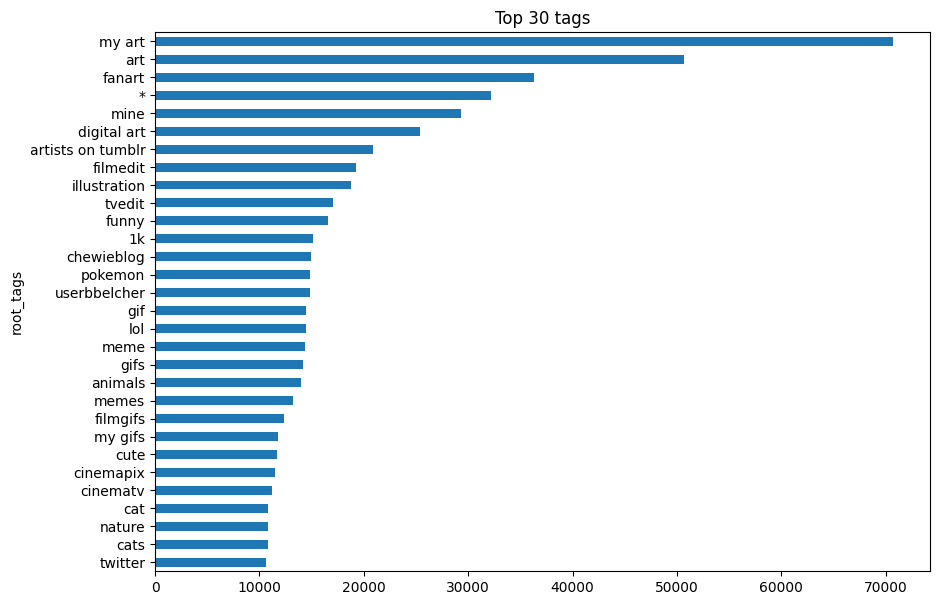

In [15]:
# Visualize top 30 tags for this day without performing any hashtag normalization
hashtags_counts = (
    df["root_tags"].progress_apply(split_tags).explode().dropna().value_counts()
)

hashtags_counts.head(30).sort_values().plot(
    kind="barh", figsize=(10, 7), title="Top 30 tags"
)
plt.show()

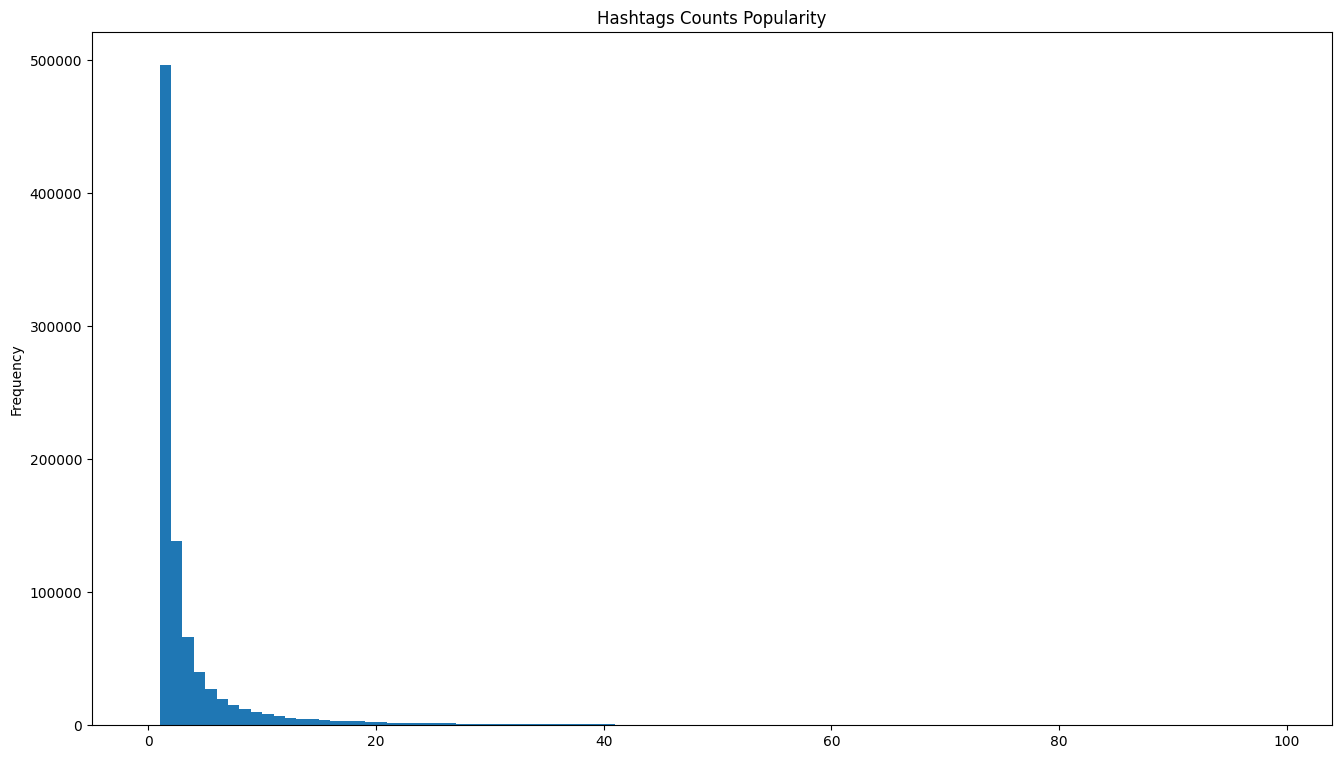

In [16]:
hashtags_counts.plot(
    kind="hist", bins=range(100), figsize=(16, 9), title="Hashtags Counts Popularity"
)
plt.show()
# This plots shows as that the vast majority of hashtags appear just once!

In [17]:
for i in range(1, 21):
    hprc = round(
        100 * (hashtags_counts <= i).astype(int).sum() / len(hashtags_counts), 3
    )
    print(f"Percentage of hashtags that appear up to {i} time(s): {hprc} %")

Percentage of hashtags that appear up to 1 time(s): 53.684 %
Percentage of hashtags that appear up to 2 time(s): 68.661 %
Percentage of hashtags that appear up to 3 time(s): 75.882 %
Percentage of hashtags that appear up to 4 time(s): 80.224 %
Percentage of hashtags that appear up to 5 time(s): 83.203 %
Percentage of hashtags that appear up to 6 time(s): 85.373 %
Percentage of hashtags that appear up to 7 time(s): 87.021 %
Percentage of hashtags that appear up to 8 time(s): 88.323 %
Percentage of hashtags that appear up to 9 time(s): 89.389 %
Percentage of hashtags that appear up to 10 time(s): 90.275 %
Percentage of hashtags that appear up to 11 time(s): 91.015 %
Percentage of hashtags that appear up to 12 time(s): 91.648 %
Percentage of hashtags that appear up to 13 time(s): 92.185 %
Percentage of hashtags that appear up to 14 time(s): 92.67 %
Percentage of hashtags that appear up to 15 time(s): 93.088 %
Percentage of hashtags that appear up to 16 time(s): 93.467 %
Percentage of hash

In [18]:
# Convert the string tags to array tags
df["root_tags_array"] = df["root_tags"].progress_apply(split_tags)
df["root_tags_count"] = df["root_tags_array"].progress_apply(len)

df["tags_array"] = df["tags"].progress_apply(split_tags)
df["tags_count"] = df["tags_array"].progress_apply(len)

100%|█| 1764542/1764542 [00:03<00:00, 551986.87
100%|█| 1764542/1764542 [00:00<00:00, 2726344.8
100%|█| 1764542/1764542 [00:03<00:00, 572458.84
100%|█| 1764542/1764542 [00:00<00:00, 2871083.9


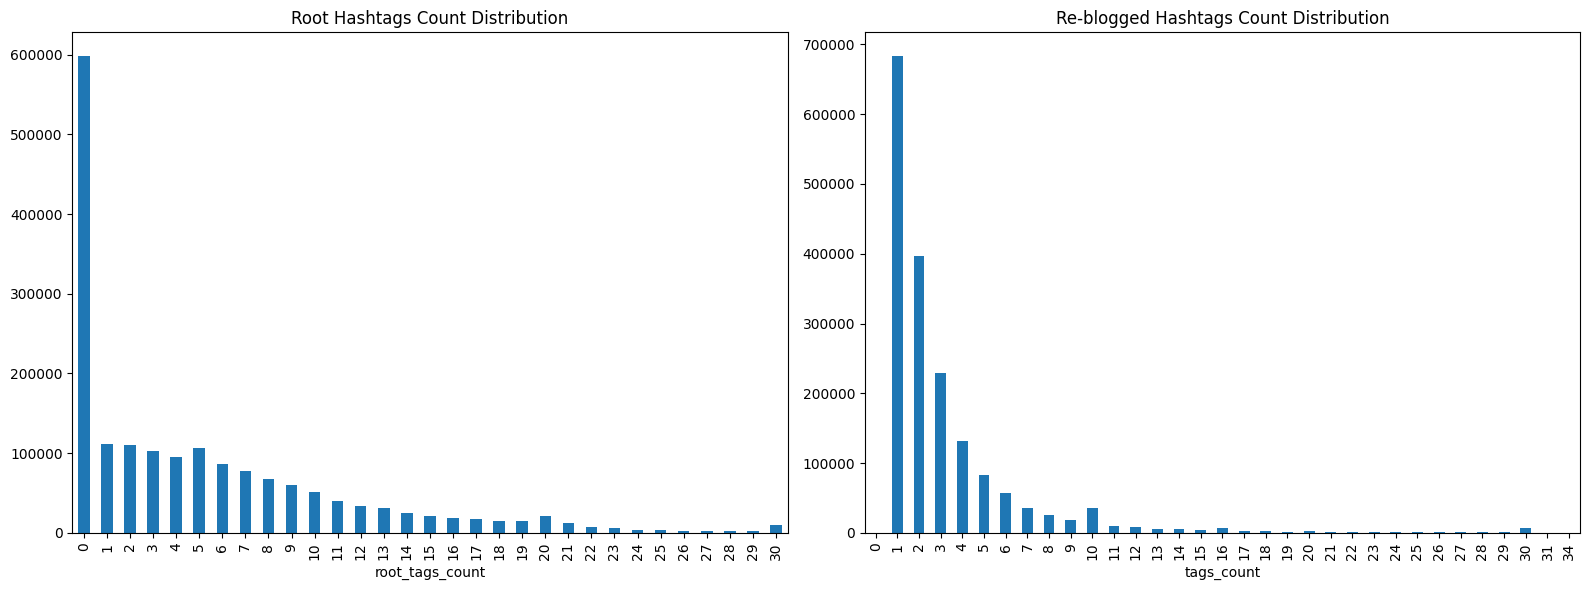

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

# First subplot for root_tags_count
df["root_tags_count"].value_counts(normalize=False).sort_index().plot(
    kind="bar",
    ax=axes[0],  # Specify the first subplot axis
    title="Root Hashtags Count Distribution",
)

# Second subplot for the re-blogged tags_count
df["tags_count"].value_counts(normalize=False).sort_index().plot(
    kind="bar",
    ax=axes[1],  # Specify the second subplot axis
    title="Re-blogged Hashtags Count Distribution",
)
plt.tight_layout()
plt.show()

There exist quite a lot of cases where we have too many hashtags. We must check for possible errors.

In [20]:
# these tags seem legit
df[df["root_tags_count"] > 29]["root_tags_array"].reset_index(drop=True)

0       [poetry, wordsnquotes, poem, wnq quote, wnq wr...
1       [uranium suite isn’t actually a bad song. it h...
2       [colorado, landscape, sunset, artwork, paintin...
3       [the last of us, the last of us hbo, tlou, tlo...
4       [wooahaes.fic, seventeen imagine, seventeen x ...
                              ...                        
9576    [ch: bradley bradshaw, ch: pete mitchell, ch: ...
9577    [whimsigothic, whimsigoth, whimsy, whimsical, ...
9578    [sea witch, fossils, ammonite, my hoard, my po...
9579    [steddie, steve harrington, eddie munson, stra...
9580    [renaissance, aesthetic, vintage, fight, war, ...
Name: root_tags_array, Length: 9581, dtype: object

In [21]:
# Note: We also have emoticons within some hashtags. For example
df.loc[1764538]["tags_array"][0]

'the way his expression changes😂'

In [22]:
# Let's now unravel the tags to get some more information
root_tags = df["root_tags_array"].explode().value_counts().reset_index()
root_tags.columns = ["tag", "count"]
root_tags["tag_len"] = root_tags["tag"].str.len()
root_tags

,tag,count,tag_len
0,my art,70708,6
1,art,50663,3
2,fanart,36311,6
3,*,32192,1
4,mine,29274,4
...,...,...,...
924411,왕이보,1,3
924412,舞者王一博,1,5
924413,演員王一博,1,5
924414,王一博歌手,1,5


In [23]:
# Let's now unravel the re-blogged tags to get some more information
reblogged_tags = df["tags_array"].explode().value_counts().reset_index()
reblogged_tags.columns = ["tag", "count"]
reblogged_tags["tag_len"] = reblogged_tags["tag"].str.len()
reblogged_tags

,tag,count,tag_len
0,art,56806,3
1,q,19323,1
2,fanart,14167,6
3,reblog,13604,6
4,video,13250,5
...,...,...,...
1808304,boys and my prerogative,1,23
1808305,I can't read this man's poetry without remembe...,1,111
1808306,im not thinking about a song rn,1,31
1808307,sadkjlfah i didn't catch it until the tags scr...,1,53


In [24]:
# As it seems, there exist some "tags" that are quite lengthy. This drives the mean to be huge.
# Let's take a closer look and check if we need to remove these.
root_tags.describe()

,count,tag_len
count,924416.000000,924416.00000
mean,9.828707,24.26080
std,159.496826,23.54277
min,1.000000,1.00000
25%,1.000000,10.00000
50%,1.000000,15.00000
75%,3.000000,28.00000
max,70708.000000,140.00000


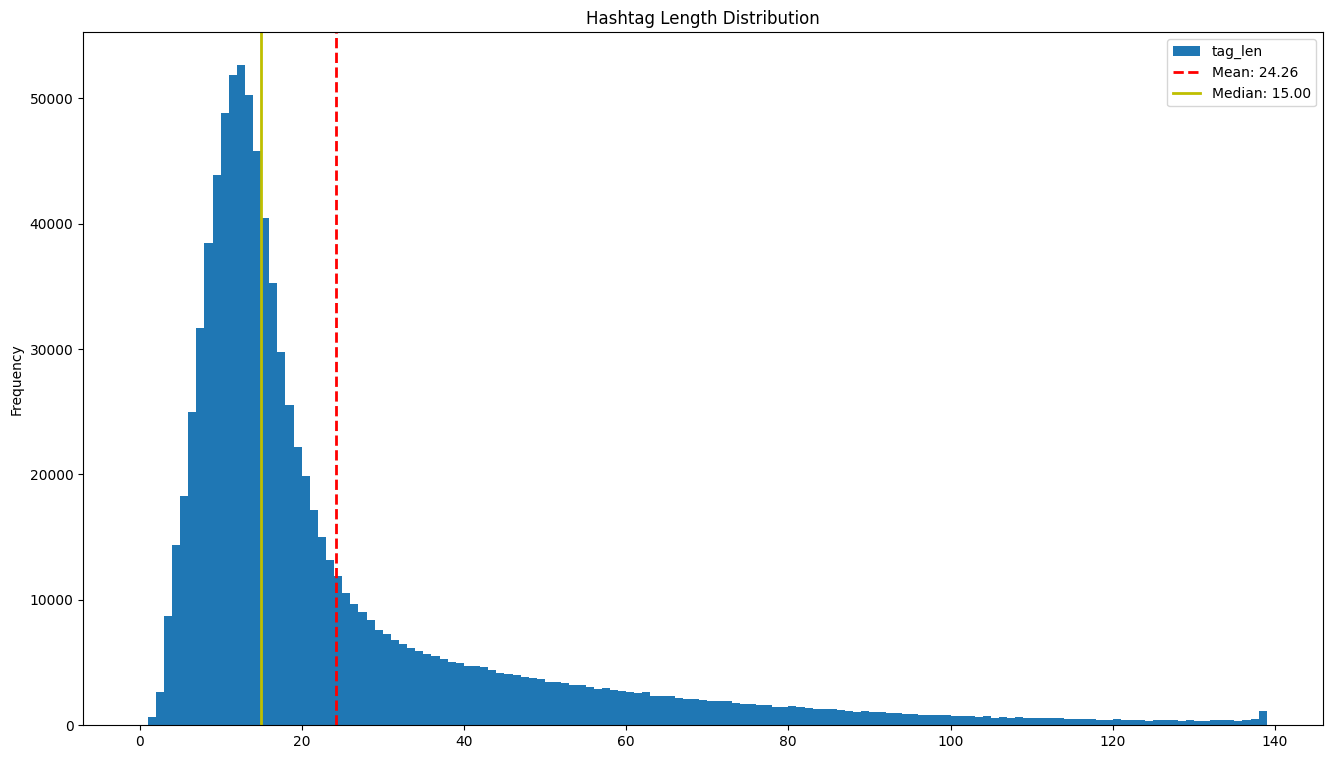

In [25]:
root_tags["tag_len"].plot(
    kind="hist", bins=range(140), figsize=(16, 9), title="Hashtag Length Distribution"
)

# Calculate the mean and median
mean_val = root_tags["tag_len"].mean()
median_val = root_tags["tag_len"].median()

# Add the mean and median lines
plt.axvline(
    mean_val, color="r", linestyle="--", linewidth=2, label=f"Mean: {mean_val:.2f}"
)
plt.axvline(
    median_val, color="y", linestyle="-", linewidth=2, label=f"Median: {median_val:.2f}"
)

# Add a legend to show the mean and median labels
plt.legend()
plt.show()

In [26]:
reblogged_tags.describe()

,count,tag_len
count,1.808309e+06,1.808309e+06
mean,3.103684e+00,2.781667e+01
std,6.289281e+01,2.535574e+01
min,1.000000e+00,1.000000e+00
25%,1.000000e+00,1.100000e+01
50%,1.000000e+00,1.800000e+01
75%,1.000000e+00,3.500000e+01
max,5.680600e+04,1.400000e+02


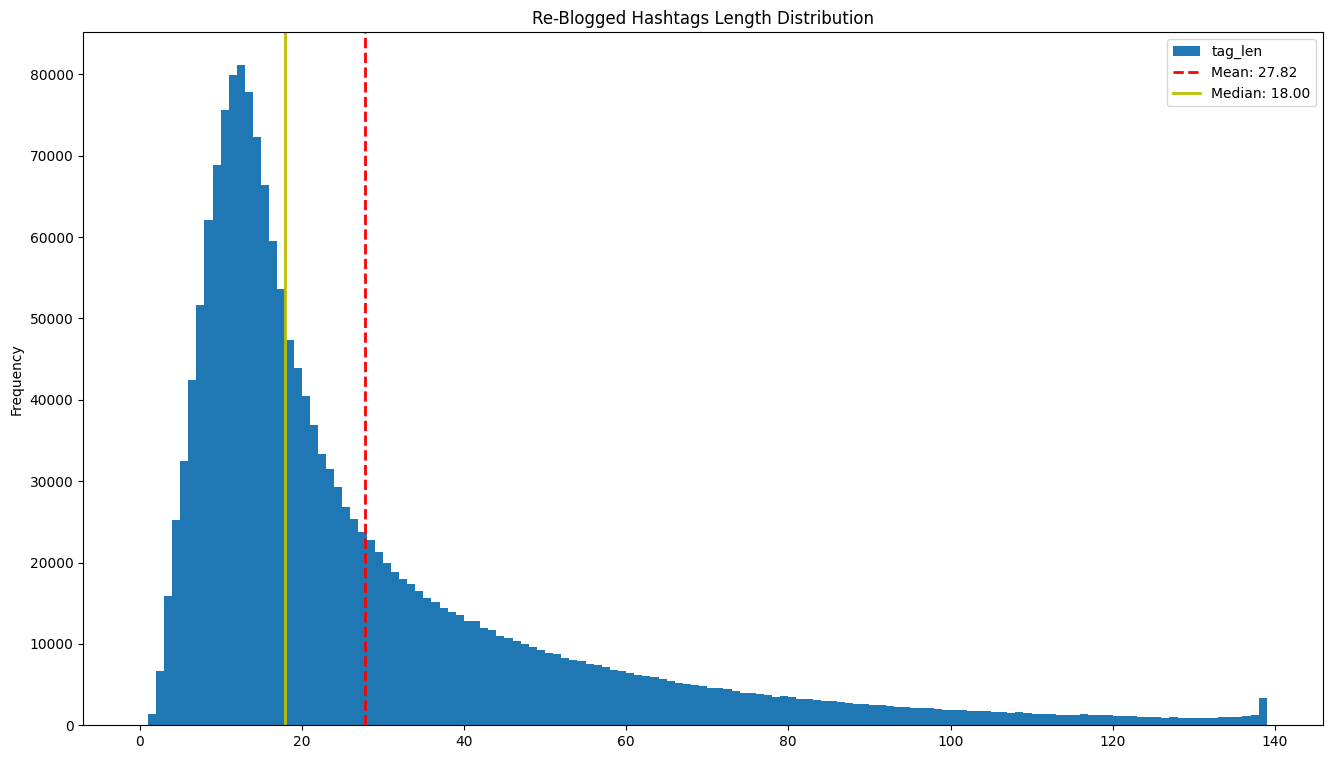

In [27]:
reblogged_tags["tag_len"].plot(
    kind="hist",
    bins=range(140),
    figsize=(16, 9),
    title="Re-Blogged Hashtags Length Distribution",
)

# Calculate the mean and median
mean_val = reblogged_tags["tag_len"].mean()
median_val = reblogged_tags["tag_len"].median()

# Add the mean and median lines
plt.axvline(
    mean_val, color="r", linestyle="--", linewidth=2, label=f"Mean: {mean_val:.2f}"
)
plt.axvline(
    median_val, color="y", linestyle="-", linewidth=2, label=f"Median: {median_val:.2f}"
)
plt.legend()  # Add a legend to show the mean and median labels
plt.show()

We need to take a loot to the hashtags that are very lengthy in order to decide what to do with them.

In [28]:
root_tags.sort_values("tag_len", ascending=False)["tag"][:50].tolist()

["i've never drawn him before so i think i did a decent job for an hour's work? attempted to suggest detail and i dare say i've improved at it",
 'now to set the record straight i am both a bj girl and a trapper girl as well as being an oliver girl but if i had to choose then its oliver',
 'stay tuned for more ace of tourney art. everyone who follows me does so for genshin and i promise ill post genshin again someday but not now',
 '605 triple spin off of the ufo in favela spinning in the air hit maker your mom then fuk ur mom throwing knife at the wall no scope 360 trip',
 'i used a ref for the second one but not the first one but i like the forst way more … they lied to me saying using ref imgs makes ur artgood',
 'I literally threatened to quit my job if they moved me to the middle school (it was for a lot of reasons but a big one was that Middle schoo',
 "the NPC comment was inspired by a 5th grader who put 'i like NPCs' on a post it note on someones back idk why but I think it was

In [29]:
reblogged_tags.sort_values("tag_len", ascending=False)["tag"][:50].tolist()

['iptv2023 bestiptvservice2023 advanceiptv nextiptv iptv smartiptv ssiptv iptvsmarters iptvsmarterspro ssiptv netiptv tivimate m3u flixiptv sm',
 'Office Space for rent in Mumbai Rent offices in Mumbai - rent Schools/clubs /gym/hospitals/clicins/call centers/ It park /college - furnishe',
 "yea as i've gotten older i've realized how like. long it can take to fully understand yourself. also sexuality/identity can be fluid anyways",
 'but also many times im reading theory and i have to pause bc its obvious the author is a white man and its giving him a blind spot hsfjsdjfs',
 'will keep this in mind if I ever want to write an au I will make it agressively german by people constantly waiting for their delayed trains',
 'AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA',
 "i.e. they see a cat or a dog or a human on the other side of the glass and understand that they won't be Got because the glass i

In [30]:
root_tags[root_tags["tag_len"] > 20].sort_values(
    ["count", "tag_len"], ascending=[False, False]
)

,tag,count,tag_len
49,puss in boots the last wish,7099,27
64,i spent way too much time editing this might p...,5710,60
132,interview with the vampire,3692,26
194,pokemon scarlet and violet,2961,26
275,this is incredibly cursed and i am incredibly ...,2383,90
...,...,...,...
924324,murder and the maiden,1,21
924326,Sie totete in Ekstase,1,21
924327,Sie tötete in Ekstase,1,21
924329,She Killed in Ecstasy,1,21


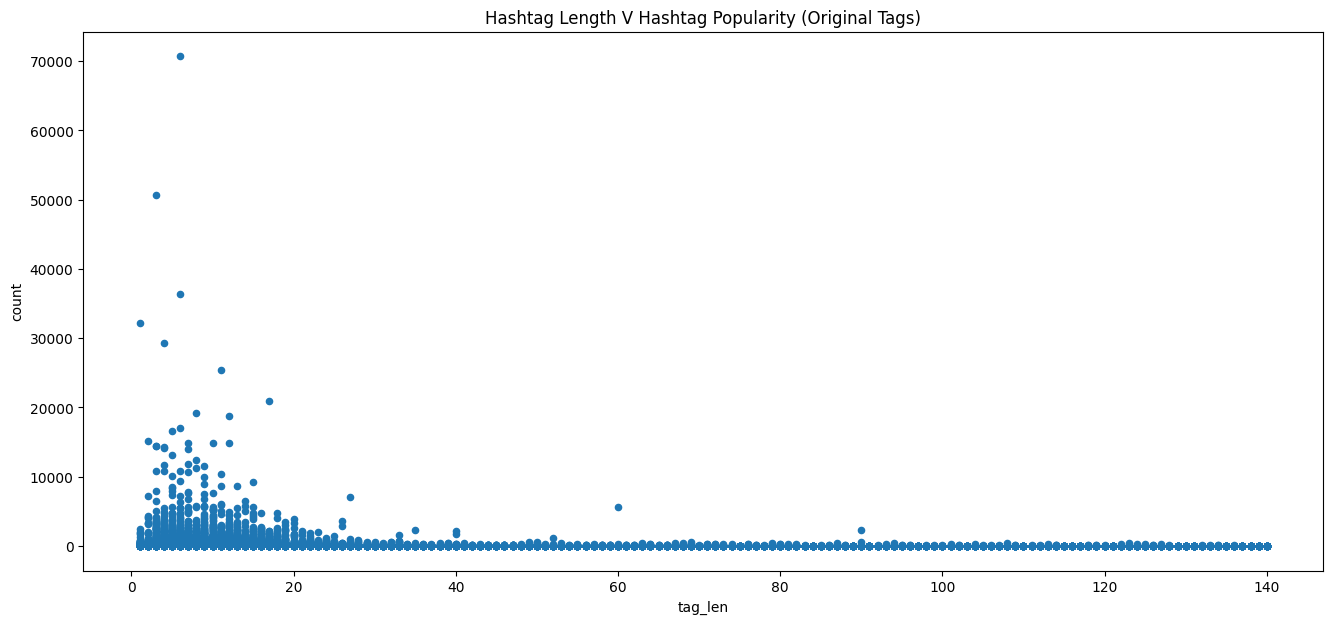

In [31]:
root_tags[["count", "tag_len"]].plot(
    kind="scatter",
    y="count",
    x="tag_len",
    figsize=(16, 7),
    title="Hashtag Length V Hashtag Popularity (Original Tags)",
)
plt.show()

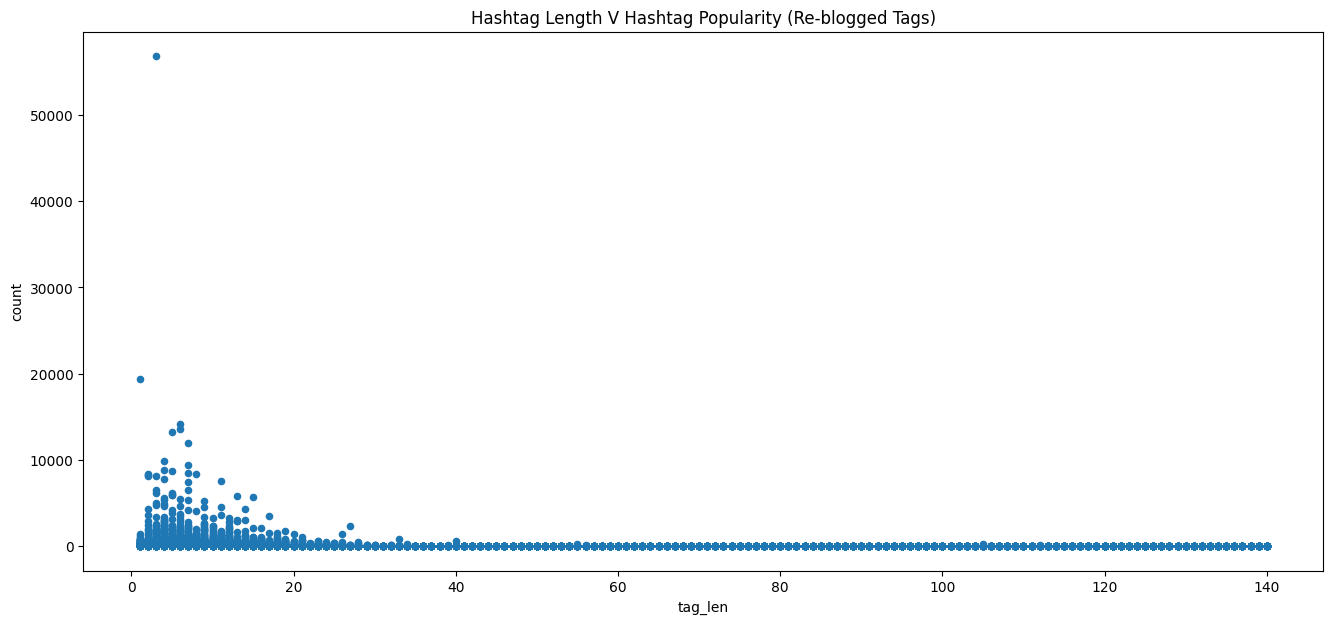

In [32]:
reblogged_tags[["count", "tag_len"]].plot(
    kind="scatter",
    y="count",
    x="tag_len",
    figsize=(16, 7),
    title="Hashtag Length V Hashtag Popularity (Re-blogged Tags)",
)
plt.show()

In [33]:
#  Compare the difference in Popularity between hashtags that have character length over and under 30.
percentiles = [0.9, 0.95, 0.99]
root_tags[root_tags.tag_len > 30]["count"].describe(percentiles=percentiles)

count    208477.000000
mean          2.969747
std          19.293104
min           1.000000
50%           1.000000
90%           5.000000
95%           9.000000
99%          29.000000
max        5710.000000
Name: count, dtype: float64

In [34]:
root_tags[root_tags.tag_len <= 30]["count"].describe(percentiles=percentiles)

count    715939.000000
mean         11.825994
std         180.889245
min           1.000000
50%           1.000000
90%          12.000000
95%          28.000000
99%         151.000000
max       70708.000000
Name: count, dtype: float64

At first it seems safe to **discard** any "hashtags" that have the following criteria:
- **The character length is over 30** &
- **The count is less that 30**

Let's take a look

In [35]:
include_condition = (root_tags["tag_len"] <= 30) | (root_tags["count"] >= 30)

root_tags[include_condition].sort_values(
    ["tag_len", "count"], ascending=[False, False]
).tag.head(20).tolist()

["and she was like okay well we'll just get an ex priest to do it or something and it was like fdskjhshb mom you're not getting my point here",
 "in case anyone's curious: the skipped episodes were man's best friend and the one you've been waiting for (aka the germany time travel one)",
 "I'm the opposite of a gatekeeper tho like watch as much as you want y'know most people I know who haven't watched it all have valid reasons",
 'it literally hit me in the middle of work that i was gonna be crying myself to sleep over this show tonight as i was talking to my coworker',
 "these characters don't have names i made them up just for this one drawing (or maybe i'll draw more of them who knows) but eeurm. yeah ^__^",
 "they've not only given us the lovely actuality of benoit/phillip but potential for james bond/phoenix buchanan and i think that's beautiful",
 'she was so exasperated explaining it like even if i DID want her (avoids saying she doesnt) she only wants to get down with a bag of b

In [36]:
root_tags[include_condition].sort_values(["tag_len", "count"], ascending=[False, False])

,tag,count,tag_len
13452,and she was like okay well we'll just get an e...,84,139
13750,in case anyone's curious: the skipped episodes...,82,139
13811,I'm the opposite of a gatekeeper tho like watc...,82,139
15411,it literally hit me in the middle of work that...,73,139
15601,these characters don't have names i made them ...,72,139
...,...,...,...
916644,🪟,1,1
916946,🌄,1,1
919823,Ɣ,1,1
921307,雀,1,1


In [37]:
candidate_tag = "10/10 learning experience; would get overly motivated by cool animation and well-written fanfic again"
df[df["root_tags_array"].progress_apply(lambda arr: candidate_tag in arr)]

# Have tried many examples one by one to get to the following point:
# These indeed are tags, but are very difficult to address using eg statistical methods. These would require a semantic methodology
# to fetch some relevant recommendations.
# Also, this example indicates that these tags appear with many counts just from the re-blogging. These should be dropped entirely
# As it messes up with the statistics.

100%|█| 1764542/1764542 [00:00<00:00, 2941697.5


,blog_url,dt,type,lang,is_reblog,tags,root_tags,body,title,root_tags_array,root_tags_count,tags_array,tags_count
2289,cerealmix.tumblr.com,2023-01-15,video,en_US,1.0,"insp,art,animation",got real greedy with the weird camera angles w...,"[""Scene from @simpleidiotpsychic‘s mp100 fic O...","<p><a href=""https://qwertyprophecy.tumblr.com/...",[got real greedy with the weird camera angles ...,9,"[insp, art, animation]",3
4305,punksalmon.tumblr.com,2023-01-15,video,pt_BR,1.0,mp100,got real greedy with the weird camera angles w...,"[""Scene from @simpleidiotpsychic‘s mp100 fic O...","<p><a href=""https://qwertyprophecy.tumblr.com/...",[got real greedy with the weird camera angles ...,9,[mp100],1
10189,thatkingbee.tumblr.com,2023-01-15,video,pt_BR,1.0,"HOLY SHIT THIS IS SO COOL!!!!!,the perspective...",got real greedy with the weird camera angles w...,"[""Scene from @simpleidiotpsychic‘s mp100 fic O...","<p><a href=""https://qwertyprophecy.tumblr.com/...",[got real greedy with the weird camera angles ...,9,"[HOLY SHIT THIS IS SO COOL!!!!!, the perspecti...",5
12185,validpseudonym.tumblr.com,2023-01-15,video,en_US,1.0,another sign for me to watch mp100,got real greedy with the weird camera angles w...,"[""Scene from @simpleidiotpsychic‘s mp100 fic O...","<p><a href=""https://qwertyprophecy.tumblr.com/...",[got real greedy with the weird camera angles ...,9,[another sign for me to watch mp100],1
19500,faexina.tumblr.com,2023-01-15,video,en_US,1.0,"mob psycho 100,video",got real greedy with the weird camera angles w...,"[""Scene from @simpleidiotpsychic‘s mp100 fic O...","<p><a href=""https://qwertyprophecy.tumblr.com/...",[got real greedy with the weird camera angles ...,9,"[mob psycho 100, video]",2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1743610,nooby-banana.tumblr.com,2023-01-15,video,en_US,1.0,"oh my god????,ANIMATION,mob psycho 100",got real greedy with the weird camera angles w...,"[""Scene from @simpleidiotpsychic‘s mp100 fic O...","<p><a href=""https://qwertyprophecy.tumblr.com/...",[got real greedy with the weird camera angles ...,9,"[oh my god????, ANIMATION, mob psycho 100]",3
1747333,lookknm.tumblr.com,2023-01-15,video,en_US,1.0,mp100,got real greedy with the weird camera angles w...,"[""Scene from @simpleidiotpsychic‘s mp100 fic O...","<p><a href=""https://qwertyprophecy.tumblr.com/...",[got real greedy with the weird camera angles ...,9,[mp100],1
1748513,nobleofthecold.tumblr.com,2023-01-15,video,en_US,1.0,"video,no sound",got real greedy with the weird camera angles w...,"[""Scene from @simpleidiotpsychic‘s mp100 fic O...","<p><a href=""https://qwertyprophecy.tumblr.com/...",[got real greedy with the weird camera angles ...,9,"[video, no sound]",2
1759606,neptunited.tumblr.com,2023-01-15,video,en_US,1.0,YOOOO,got real greedy with the weird camera angles w...,"[""Scene from @simpleidiotpsychic‘s mp100 fic O...","<p><a href=""https://qwertyprophecy.tumblr.com/...",[got real greedy with the weird camera angles ...,9,[YOOOO],1


In [38]:
# Keeping the tags that appear at least once has a really long tail
filtered_root_tags = root_tags[root_tags["tag_len"] <= 30].copy()
filtered_root_tags

,tag,count,tag_len
0,my art,70708,6
1,art,50663,3
2,fanart,36311,6
3,*,32192,1
4,mine,29274,4
...,...,...,...
924411,왕이보,1,3
924412,舞者王一博,1,5
924413,演員王一博,1,5
924414,王一博歌手,1,5


In [39]:
# Aproximately 78% of the original number of hashtags were kept
filtered_root_tags.shape[0] / root_tags.shape[0]

0.7744770752561617

In [40]:
# If we remove the hashtags that appear at least once we will drop the long tail
filtered_root_tags = root_tags[
    (root_tags["tag_len"] <= 30) & (root_tags["count"] > 1)
].copy()
filtered_root_tags

,tag,count,tag_len
0,my art,70708,6
1,art,50663,3
2,fanart,36311,6
3,*,32192,1
4,mine,29274,4
...,...,...,...
428146,Kudo Shinichi,2,13
428147,rise Cassandra jones,2,20
428148,redecorating,2,12
428149,I love turlough,2,15


In [41]:
# Aproximately 39% of the original number of hashtags
filtered_root_tags.shape[0] / root_tags.shape[0]

0.38560453302409303

In [42]:
root_tags

,tag,count,tag_len
0,my art,70708,6
1,art,50663,3
2,fanart,36311,6
3,*,32192,1
4,mine,29274,4
...,...,...,...
924411,왕이보,1,3
924412,舞者王一博,1,5
924413,演員王一博,1,5
924414,王一博歌手,1,5


In [43]:
def cluster_hashtags(df, count_column, hashtag_column, n_clusters=3):
    """
    Clusters hashtags into tiers using K-means based on their frequency of occurrence.

    Parameters:
        df: pd.DataFrame
            DataFrame containing hashtags and their counts.
        count_column: str
            Column name containing the count/frequency of the hashtags.
        hashtag_column: str
            Column name containing the hashtags.
        n_clusters: int
            Number of clusters to form (tiers).

    Returns:
        pd.DataFrame
            DataFrame with an additional 'popularity_tier' column.
    """

    # Extract the count data and reshape it for clustering
    counts = df[[count_column]].values

    # Initialize and fit KMeans model
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    df["tier"] = kmeans.fit_predict(counts)

    # Sort clusters by the mean of the counts in each cluster to assign meaningful tier names
    cluster_centers = kmeans.cluster_centers_.flatten()
    sorted_cluster_indices = cluster_centers.argsort()

    # Map cluster indices to tier names based on sorted cluster centers
    tier_mapping = {
        sorted_cluster_indices[i]: f"Tier {i + 1}" for i in range(n_clusters)
    }
    df["popularity_tier"] = df["tier"].map(tier_mapping)

    # Drop the 'tier' column since we only want 'popularity_tier'
    df = df.drop(columns=["tier"])

    return df


# Cluster hashtags into tiers
root_tags_with_clusters = cluster_hashtags(
    filtered_root_tags, count_column="count", hashtag_column="tag", n_clusters=5
)

In [44]:
root_tags_with_clusters.groupby("popularity_tier")["count"].describe()

,count,mean,std,min,25%,50%,75%,max
popularity_tier,,,,,,,,
Tier 1,354419.0,13.699314,36.231143,2.0,2.00,4.0,9.00,492.0
Tier 2,1783.0,972.122827,482.034966,493.0,604.50,788.0,1197.00,2474.0
Tier 3,224.0,4040.776786,1563.549223,2507.0,2844.25,3475.5,4781.00,9421.0
Tier 4,31.0,15874.612903,6618.279553,9962.0,11356.00,14345.0,16801.00,36311.0
Tier 5,2.0,60685.500000,14173.955429,50663.0,55674.25,60685.5,65696.75,70708.0


In [45]:
root_tags_with_clusters.head(20)

,tag,count,tag_len,popularity_tier
0,my art,70708,6,Tier 5
1,art,50663,3,Tier 5
2,fanart,36311,6,Tier 4
3,*,32192,1,Tier 4
4,mine,29274,4,Tier 4
5,digital art,25387,11,Tier 4
6,artists on tumblr,20900,17,Tier 4
7,filmedit,19209,8,Tier 4
8,illustration,18795,12,Tier 4
9,tvedit,17065,6,Tier 4


Another more simplistic way to cluster the hashtags are based on the percentiles

In [46]:
percentiles = [0.5, 0.8, 0.95, 0.99]

percentile_values = root_tags_with_clusters["count"].quantile(percentiles)

bins = [0] + list(percentile_values) + [root_tags_with_clusters["count"].max()]

percentiles_labels = ["Low", "Medium", "High", "Very High", "Top 1%"]

root_tags_with_clusters["business_popularity"] = pd.cut(
    root_tags_with_clusters["count"],
    bins=bins,
    labels=percentiles_labels,
    include_lowest=True,
)

root_tags_with_clusters

,tag,count,tag_len,popularity_tier,business_popularity
0,my art,70708,6,Tier 5,Top 1%
1,art,50663,3,Tier 5,Top 1%
2,fanart,36311,6,Tier 4,Top 1%
3,*,32192,1,Tier 4,Top 1%
4,mine,29274,4,Tier 4,Top 1%
...,...,...,...,...,...
428146,Kudo Shinichi,2,13,Tier 1,Low
428147,rise Cassandra jones,2,20,Tier 1,Low
428148,redecorating,2,12,Tier 1,Low
428149,I love turlough,2,15,Tier 1,Low


In [47]:
root_tags_with_clusters["business_popularity"].value_counts()

business_popularity
Low          195710
Medium        89971
High          53043
Very High     14174
Top 1%         3561
Name: count, dtype: int64

In [48]:
root_tags_with_clusters.groupby("business_popularity")["count"].describe()

/var/folders/_q/3_4v8_4x7wx6dzy3gnrlfxb80000gn/T/ipykernel_16479/960403260.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  root_tags_with_clusters.groupby("business_popularity")["count"].describe()


,count,mean,std,min,25%,50%,75%,max
business_popularity,,,,,,,,
Low,195710.0,2.614072,0.758288,2.0,2.0,2.0,3.0,4.0
Medium,89971.0,7.383301,2.176505,5.0,5.0,7.0,9.0,12.0
High,53043.0,25.827461,12.221718,13.0,16.0,22.0,33.0,60.0
Very High,14174.0,122.359602,57.838889,61.0,77.0,102.0,152.0,294.0
Top 1%,3561.0,1074.708228,2316.480920,295.0,388.0,549.0,983.0,70708.0
